In [1]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, GPT2ForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader, TensorDataset
import torch
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the data
file_path = 'processed_lexioms.csv'
df = pd.read_csv(file_path)

In [3]:
# Mapping polarity to numerical labels
label_mapping = {'compound_pos': 1, 'positive': 1, 'compound_neg': 0, 'negative': 0}  # Adjust based on your dataset
df['label'] = df['Polarity'].map(label_mapping)

# Filter out rows with missing labels
df = df.dropna(subset=['label'])

In [4]:
# Initialize model and tokenizer
model_name = "aubmindlab/aragpt2-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Add padding token if not present
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenizer.pad_token = tokenizer.eos_token  # Setting pad_token to eos_token

def tokenize_data(df, tokenizer):
    return tokenizer(
        list(df['Term']),
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )

encodings = tokenize_data(df, tokenizer)
labels = torch.tensor(df['label'].values)

dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

C:\Users\Kevin\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
def train(model, train_loader, optimizer, lr_scheduler, device):
    model.train()
    progress_bar = tqdm(train_loader, desc="Training")
    total_loss = 0
    for batch in progress_bar:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
    return total_loss / len(train_loader)

def evaluate(model, val_loader, device):
    model.eval()
    progress_bar = tqdm(val_loader, desc="Evaluating")
    all_labels = []
    all_preds = []
    total_loss = 0
    for batch in progress_bar:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        
        total_loss += loss.item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
    
    accuracy = np.mean(np.array(all_labels) == np.array(all_preds))
    print(f"Validation Accuracy: {accuracy:.4f}")
    return total_loss / len(val_loader), accuracy, all_labels, all_preds

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at aubmindlab/aragpt2-base and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20


C:\Users\Kevin\anaconda3\Lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Accuracy: 0.7515
Epoch 2/20


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Accuracy: 0.8060
Epoch 3/20


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Accuracy: 0.8094
Epoch 4/20


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Accuracy: 0.8321
Epoch 5/20


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Accuracy: 0.8380
Epoch 6/20


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Accuracy: 0.8547
Epoch 7/20


Training:   0%|          | 0/298 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/75 [00:00<?, ?it/s]

Validation Accuracy: 0.8556
Early stopping triggered
Fine-tuned model and evaluation results saved.


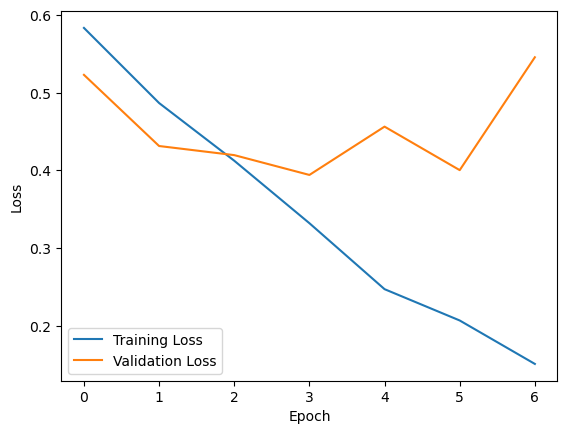

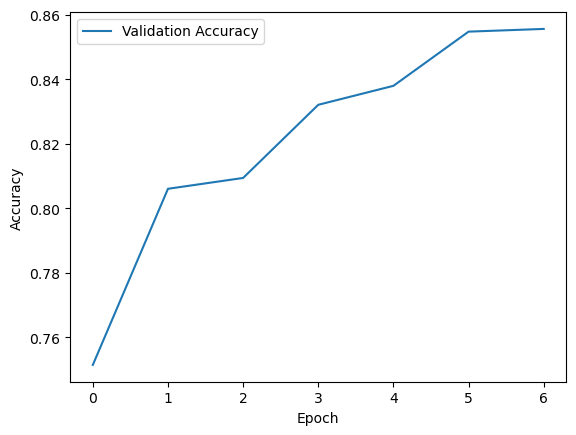

In [6]:
# Initialize model
model = GPT2ForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Resize model embeddings to accommodate new special tokens
model.resize_token_embeddings(len(tokenizer))

# Set the padding token ID in the model configuration
model.config.pad_token_id = tokenizer.pad_token_id

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Prepare optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 20
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# Early stopping parameters
patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

train_losses = []
val_losses = []
accuracies = []

# Training and evaluation loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss = train(model, train_loader, optimizer, lr_scheduler, device)
    val_loss, accuracy, all_labels, all_preds = evaluate(model, val_loader, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accuracies.append(accuracy)
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model
        model.save_pretrained("best_fine_tuned_aragpt2")
        tokenizer.save_pretrained("best_fine_tuned_aragpt2")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break

# Save evaluation results
results_df = pd.DataFrame({
    'label': all_labels,
    'prediction': all_preds
})
results_df.to_excel('evaluation_results.xlsx', index=False)
print("Fine-tuned model and evaluation results saved.")

# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()